In [41]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [42]:
df = pd.read_csv('/content/SAMSUNG.csv')
df1=df.reset_index()['Close']

In [43]:
df1

0       44387.5
1       44387.5
2       44387.5
3       44850.0
4       44250.0
         ...   
1915    77600.0
1916    75200.0
1917    73500.0
1918    73500.0
1919    75400.0
Name: Close, Length: 1920, dtype: float64

In [44]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [45]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [46]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [47]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [48]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [49]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [50]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train, epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 10s 166ms/step - loss: 0.0610
Epoch 2/100
20/20 [==============================] - 3s 166ms/step - loss: 0.0065
Epoch 3/100
20/20 [==============================] - 4s 197ms/step - loss: 0.0028
Epoch 4/100
20/20 [==============================] - 4s 219ms/step - loss: 0.0023
Epoch 5/100
20/20 [==============================] - 3s 169ms/step - loss: 0.0022
Epoch 6/100
20/20 [==============================] - 3s 165ms/step - loss: 0.0020
Epoch 7/100
20/20 [==============================] - 4s 224ms/step - loss: 0.0019
Epoch 8/100
20/20 [==============================] - 4s 182ms/step - loss: 0.0018
Epoch 9/100
20/20 [==============================] - 3s 165ms/step - loss: 0.0018
Epoch 10/100
20/20 [==============================] - 3s 166ms/step - loss: 0.0017
Epoch 11/100
20/20 [==============================] - 5s 251ms/step - loss: 0.0016
Epoch 12/100
20/20 [==============================] - 3s 167ms/step - loss: 0.0015
Epoch 13/100

In [51]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

15/15 [==============================] - 1s 39ms/step


In [52]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [53]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 71110.61895847207


In [54]:
# Dự đoán 30 ngày tiếp theo
temp_input = test_data[-time_step:].reshape(1, -1).tolist()[0]
lst_output_30 = []
n_steps = time_step
for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_30.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_30.extend(yhat.tolist())

In [55]:

# Chuẩn hóa lại dự đoán 30 ngày
lst_output_30 = scaler.inverse_transform(lst_output_30)


In [56]:
# Dự đoán 60 ngày tiếp theo
temp_input = test_data[-time_step:].reshape(1, -1).tolist()[0]
lst_output_60 = []
n_steps = time_step
for i in range(60):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

In [57]:

# Chuẩn hóa lại dự đoán 60 ngày
lst_output_60 = scaler.inverse_transform(lst_output_60)


In [58]:
# Dự đoán 90 ngày tiếp theo
temp_input = test_data[-time_step:].reshape(1, -1).tolist()[0]
lst_output_90 = []
n_steps = time_step
for i in range(90):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())

In [59]:

# Chuẩn hóa lại dự đoán 90 ngày
lst_output_90 = scaler.inverse_transform(lst_output_90)


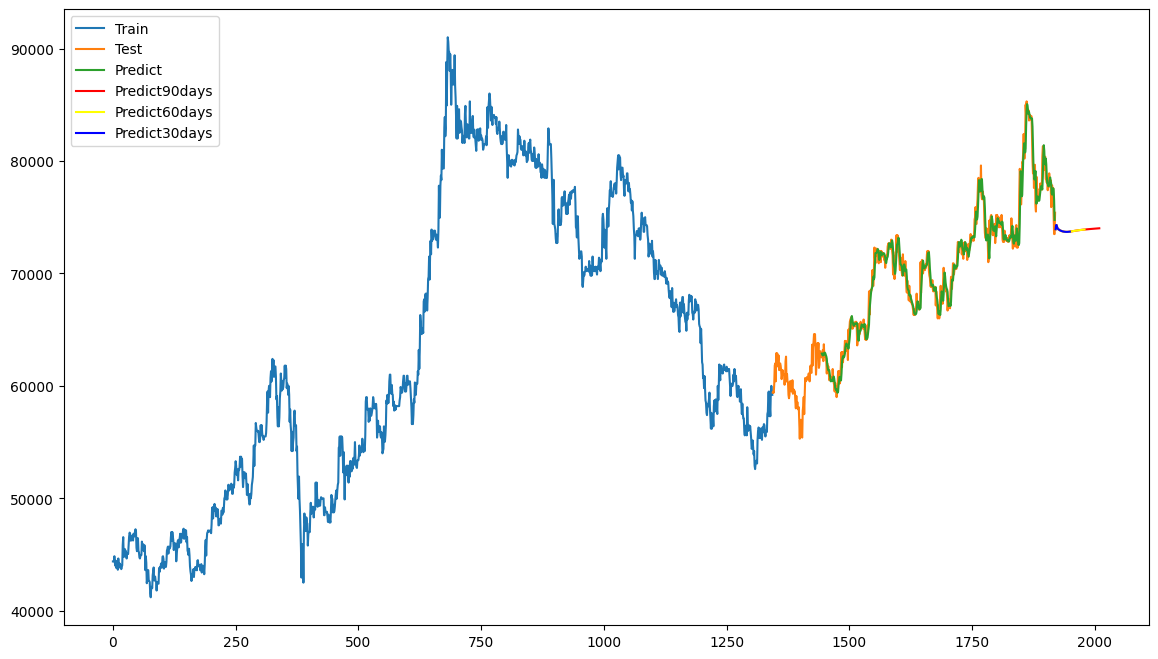

In [60]:

# Plot the results
plt.figure(figsize=(14, 8))

# Plot training data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))

# Plot testing data
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

# Plot predicted data
y_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(y_pred_index, y_pred)

# Plot future predictions
predict90_days_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 90, step=1)
plt.plot(predict90_days_index, lst_output_90, color='red')


predict60_days_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 60, step=1)
plt.plot(predict60_days_index, lst_output_60, color='yellow')


predict30_days_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(predict30_days_index, lst_output_30, color='blue')



plt.legend(['Train', 'Test', 'Predict', 'Predict90days' , 'Predict60days', 'Predict30days' ])
plt.show()

In [61]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
# Tính toán MAPE và RMSE
mape = mean_absolute_percentage_error(ytest, y_pred)
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
mse = mean_squared_error(ytest, y_pred)

print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAPE: {mape:.4f}')

# results_VARMA = pd.DataFrame([['VARMA', rmse, mape, mse]],
#                columns = ['Model', 'RMSE', 'MSE', 'MAPE'])
# results_VARMA

RMSE: 71110.6106
MSE: 5056718944.2334
MAPE: 121259.0938
